In [1]:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from pathlib import Path
import torch.nn.functional as F

from train_model import get_n_params, train_model
from time import time
import copy
from IPython.display import clear_output
from layers import BayesianConv2d

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
from pathlib import Path

class LIDC_IDRI(torch.utils.data.Dataset):
    def __init__(self, transform, mode, legions, data_path='LIDC_crops/LIDC_DLCV_version'):
        'Initialization'
        self.transform = transform
        data_path += "/" + mode
        print(data_path)
        self.image_paths = [data_path + "/images/" + path.name for path in Path(data_path + "/images").rglob('*')]
        print(data_path + "/images")
        all_target_paths = [data_path + "/lesions/" + path.name for path in Path(data_path + "/lesions").rglob('*')]
        
        self.target_paths = []
        for legion in legions:
            legion_path = [path for path in all_target_paths if path.endswith(f"l{legion}.png")]
            self.target_paths.append(legion_path)
        self.image_paths= self.image_paths
        self.target_paths[0] = self.target_paths[0]
        im = Image.open(self.image_paths[0])
        X = self.transform(im)
        self.dim = X.shape[1]
        
    def __len__(self):
        return len(self.image_paths)
    
    def get_input_im(self, idx):
        return Image.open(self.image_paths[idx])
    
    def get_legion_im(self, idx):
        if len(self.target_paths) == 1:
            return Image.open(self.target_paths[0][idx])
        else:
            return None
    
    def get_x_tensor(self, idx):
        input_im = self.get_input_im(idx)
        return self.transform(input_im)
    
    def get_y_tensor(self, idx):
        if len(self.target_paths) == 1:
            target_im = self.get_legion_im(idx)
            return self.transform(target_im)
        else:
            return None
    
    def __getitem__(self, idx):
        X = self.get_x_tensor(idx)
        y = self.get_y_tensor(idx)
        return X, y
    
    def im_show(self, idx):
        input_im = self.get_input_im(idx)
        plt.imshow(input_im)
        
    def legion_show(self, idx):
        target_im = self.get_legion_im(idx)
        plt.imshow(target_im)

In [5]:
batch_size = 32
transform = transforms.Compose([transforms.ToTensor()])

data_train = LIDC_IDRI(transform, mode='train', legions=[0])
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True, num_workers=0)
data_val = LIDC_IDRI(transform, mode='val', legions=[0])
val_loader = DataLoader(data_val, batch_size=1, shuffle=True, num_workers=0)
data_test = LIDC_IDRI(transform, mode='test', legions=[0])
test_loader = DataLoader(data_test, batch_size=1, shuffle=True, num_workers=0)

LIDC_crops/LIDC_DLCV_version/train
LIDC_crops/LIDC_DLCV_version/train/images
LIDC_crops/LIDC_DLCV_version/val
LIDC_crops/LIDC_DLCV_version/val/images
LIDC_crops/LIDC_DLCV_version/test
LIDC_crops/LIDC_DLCV_version/test/images


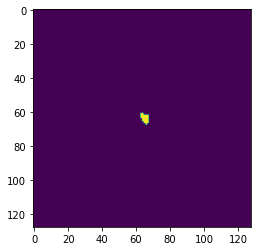

In [4]:
im1 = data_train.get_input_im(69)
y1_tensor = data_train.get_y_tensor(69)
data_train.legion_show(69)

# Find class balance

In [5]:
# Iterate over data.
num_ones = 0.0
num_zeros = 0.0
for inputs, labels in train_loader:
    num_ones += torch.sum(labels == 1)
    num_zeros += torch.sum(labels == 0)

In [6]:
print("Ratio of background to foreground class", num_zeros / num_ones)
train_weight = num_zeros / num_ones

Ratio of background to foreground class tensor(168.7268)


In [7]:
# Iterate over data.
num_ones = 0.0
num_zeros = 0.0
for inputs, labels in val_loader:
    num_ones += torch.sum(labels == 1)
    num_zeros += torch.sum(labels == 0)

In [8]:
print("Ratio of background to foreground class", num_zeros / num_ones)

Ratio of background to foreground class tensor(192.5632)


In [9]:
# Iterate over data.
num_ones = 0.0
num_zeros = 0.0
for inputs, labels in test_loader:
    num_ones += torch.sum(labels == 1)
    num_zeros += torch.sum(labels == 0)

In [10]:
print("Ratio of background to foreground class", num_zeros / num_ones)

Ratio of background to foreground class tensor(153.8242)


# U-net Model

In [11]:
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet,self).__init__()
        def blue(in_dim, out_dim):
            return [nn.Conv2d(in_dim, out_dim, kernel_size=(3,3),stride=(1,1), padding=1),
                    nn.ReLU()]
        
        def red():
            return [nn.MaxPool2d(2)]
        
        def teal(in_dim):
            return [nn.Conv2d(in_dim, 1, kernel_size=(1,1),stride=(1,1))]

        def green(in_dim, out_dim):
            return [torch.nn.ConvTranspose2d(in_dim, out_dim, kernel_size=(2,2), stride=(2,2))]
        
        def grey(x, crop_size):
            return F.interpolate(x, crop_size)
        
        self.red1 = nn.Sequential(*red())
        self.red2 = nn.Sequential(*red())
        self.red3 = nn.Sequential(*red())
        self.green1 = nn.Sequential(*green(256, 256))
        self.green2 = nn.Sequential(*green(128, 128))
        self.green3 = nn.Sequential(*green(64, 64))
        
        self.crop1 = lambda x: grey(x, [16, 16])
        self.crop2 = lambda x: grey(x, [24, 24])
        self.crop3 = lambda x: grey(x, [40, 40])
        
        layers = blue(1, 64)
        layers.extend(blue(64, 64))
        self.block1 = nn.Sequential(*layers)
        
        layers = blue(64, 128)
        layers.extend(blue(128, 128))
        self.block2 = nn.Sequential(*layers)
        
        layers = blue(128, 256)
        layers.extend(blue(256, 256))
        self.block3 = nn.Sequential(*layers)
        
        layers = blue(256, 512)
        layers.extend(blue(512, 256))
        self.block4 = nn.Sequential(*layers)
        
        layers = blue(512, 256)
        layers.extend(blue(256, 128))
        self.block5 = nn.Sequential(*layers)
        
        layers = blue(256, 128)
        layers.extend(blue(128, 64))
        self.block6 = nn.Sequential(*layers)
        
        layers = blue(128, 64)
        layers.extend(blue(64, 64))
        layers.extend(teal(64))
        self.block7 = nn.Sequential(*layers)
        self.print = False
        
    def forward(self, x):
        print(10*"*", "Downwards", 10*"*") if self.print else print("", end="")
        print("Input shape:\n", x.shape) if self.print else print("", end="")
        x1 = self.block1(x)
        print("After blue convolutions:\n", x.shape) if self.print else print("", end="")
        x = self.red1(x1)
        print("After red max-pooling:\n", x.shape) if self.print else print("", end="")
        
        x2 = self.block2(x)
        print("After blue convolutions:\n", x.shape) if self.print else print("", end="")
        x = self.red2(x2)
        print("After red max-pooling:\n", x.shape) if self.print else print("", end="")
        
        x3 = self.block3(x)
        print("After blue convolutions:\n", x.shape) if self.print else print("", end="")
        x = self.red3(x3)
        print("After red max-pooling:\n", x.shape) if self.print else print("", end="")
        
        print("\n\n", 10*"*", "Middle", 10*"*") if self.print else print("", end="")
        x = self.block4(x)
        print("After blue convolutions:\n", x.shape) if self.print else print("", end="")
        x = self.green1(x)
        print("After green up-conv\n", x.shape) if self.print else print("", end="")
        
        print("\n\n", 10*"*", "Upwards", 10*"*") if self.print else print("", end="")
        print("Concat", x.shape, "and", x3.shape, "on dim=1") if self.print else print("", end="")
        x = torch.cat([x3, x], dim=1)
        print(x.shape) if self.print else print("", end="")
        x = self.block5(x)
        print("After blue convolutions:\n", x.shape) if self.print else print("", end="")
        x = self.green2(x)
        print("After green up-conv\n", x.shape) if self.print else print("", end="")
        
        print("Concat", x.shape, "and", x2.shape, "on dim=1") if self.print else print("", end="")
        x = torch.cat([x2, x], dim=1)
        print(x.shape) if self.print else print("", end="")
        x = self.block6(x) 
        print("After blue convolutions:\n", x.shape) if self.print else print("", end="")
        x = self.green3(x)
        print("After green up-conv\n", x.shape) if self.print else print("", end="")
         
        print("Concat", x.shape, "and", x1.shape, "on dim=1") if self.print else print("", end="")
        x = torch.cat([x1, x], dim=1)
        print(x.shape) if self.print else print("", end="")
        x = self.block7(x)
        print("After blue convolutions:\n", x.shape) if self.print else print("", end="")
        return torch.sigmoid(x)

In [12]:
def bce_total_variation(y_real, y_pred):
    y_sig = torch.clamp(torch.sigmoid(y_pred), 1e-4, 1-1e-4)

    total_variation = (y_sig[:,:,1:,:]- y_sig[:,:,:-1,:]).mean() + (y_sig[:,:,:,1:]  - y_sig[:,:,:,:-1]).mean()

    return focal_loss(y_real, y_pred) + total_variation

In [13]:
def focal_loss_q(y_real, y_pred,gamma=2):
    sigy = torch.clamp(torch.sigmoid(y_pred), 1e-4, 1-1e-4)
    loss = (1-sigy) ** gamma * torch.log(sigy) + (1-y_real) * torch.log(1-sigy)

    loss = -loss.mean()

    return loss

In [14]:
def train(model, opt, loss_fn, epochs, data_tr, val_loader, patience):
    train_loss_lst = []
    val_loss_lst = []
    patience_counter = 0
    best_val_loss = 1e15
    best_model_wts = copy.deepcopy(model.state_dict())
    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate metrics to show the user
            avg_loss += loss / len(data_tr)
        print(' - loss: %f' % avg_loss)
        train_loss_lst.append(avg_loss)

        avg_loss_val = 0
        model.eval()  # testing mode
        for X_batch, Y_batch in val_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # forward
            with torch.set_grad_enabled(False):
                Y_pred = model(X_batch)
                loss = loss_fn(Y_pred, Y_batch)  # forward-pass
                avg_loss_val += loss / len(data_val)

        if avg_loss_val < best_val_loss:
            best_val_loss = avg_loss_val
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, f"Model Checkpoints/Unet_bce_weighted_loss_lr{lr}.pth")
            patience_counter = 0
        else:
            patience_counter += 1

        val_loss_lst.append(avg_loss_val)
        print(' - val loss: %f' % avg_loss_val)
        if patience_counter > patience:
            print("Early stopping after", epoch, "epochs")
            break

    return train_loss_lst, val_loss_lst, best_model_wts

In [15]:
def validate(model, loss_fn, data_val):
    avg_loss_val = 0
    model.eval()  # testing mode
    torch.no_grad()
    for X_batch, Y_batch in data_val:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        # forward
        Y_pred = model(X_batch).cpu()
        loss = loss_fn(Y_pred, Y_batch)  # forward-pass
        avg_loss_val += loss / len(data_val)
    return avg_loss_val

# Train Model

In [19]:
loss_fn = nn.BCEWithLogitsLoss(pos_weight=train_weight)
net = UNet()
opt = torch.optim.Adam(net.parameters(), lr=5e-4)
net.to(device)
net.train()  # train mode
for X_batch, Y_batch in train_loader:
    X_batch = X_batch.to(device)
    Y_batch = Y_batch.to(device)

    # set parameter gradients to zero
    opt.zero_grad()

    # forward
    Y_pred = net(X_batch)
    loss = loss_fn(Y_pred, Y_batch)
    loss.backward()
    opt.step()

In [ ]:
assert 1 > 2

In [ ]:
# Load
epochs = 30
patience = 3
net = UNet()
net.to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=train_weight)
opt = torch.optim.Adam(net.parameters(), lr=5e-4)
train_loss_lst, val_loss_lst, best_state = train(net, opt, loss_fn, epochs, train_loader, val_loader, patience)

In [ ]:
y = y.to(device)
loss_fn(y_out, y)

In [ ]:
train_weight

In [ ]:
assert 1 == 2

In [ ]:
legion = 0

lr = 1e-4

torch.save(net.state_dict(), f"Model Checkpoints/lr{lr}_legion{legion}_30epochs_focal_loss_{int(time())}.pth")

# Load Model

In [16]:
net = UNet()
net.to(device)
net.load_state_dict(torch.load("Model Checkpoints/Unet_BCEWithLogitsLoss()_lr0.0001.pth"))

<All keys matched successfully>

In [22]:
test_loader = DataLoader(data_test, batch_size=1, shuffle=True, num_workers=0)
net.eval()
y_pred = []
net.print = False
for inputs, labels in val_loader:
    inputs = inputs.to(device)
    outputs = net(inputs)
    y_pred.append(torch.sigmoid(outputs).cpu().detach().numpy())

In [18]:
y_pred[0]

array([[[[ 0.50000107,  0.5       ,  0.5       , ...,  0.5       ,
           0.5       ,  0.5       ],
         [ 0.50000012,  0.5       ,  0.5       , ...,  0.5       ,
           0.5       ,  0.5       ],
         [ 0.5       ,  0.5       ,  0.5       , ...,  0.5       ,
           0.5       ,  0.5       ],
         ..., 
         [ 0.50015926,  0.50001234,  0.50000161, ...,  0.5       ,
           0.5       ,  0.5       ],
         [ 0.50028312,  0.50002044,  0.50000358, ...,  0.5       ,
           0.5       ,  0.5       ],
         [ 0.50117487,  0.5000807 ,  0.5000177 , ...,  0.5       ,
           0.5       ,  0.5       ]]]], dtype=float32)

Accuracy: 0.987365722656


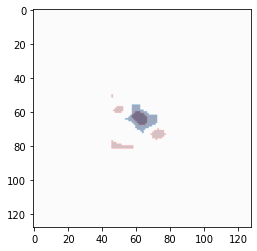

Accuracy: 0.983825683594


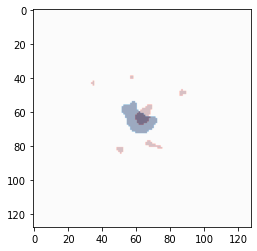

Accuracy: 0.982666015625


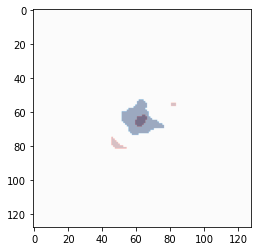

Accuracy: 0.972595214844


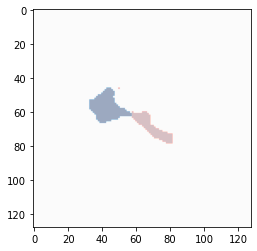

Accuracy: 0.971618652344


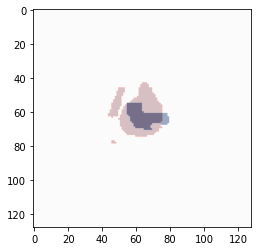

Accuracy: 0.984497070313


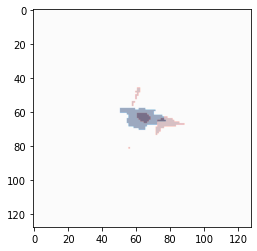

Accuracy: 0.966796875


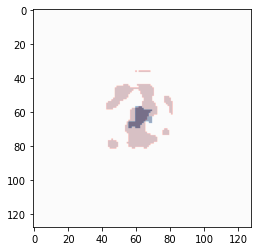

Accuracy: 0.949340820313


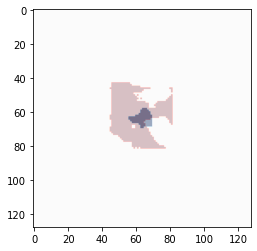

Accuracy: 0.988464355469


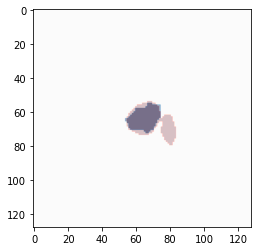

Accuracy: 0.979797363281


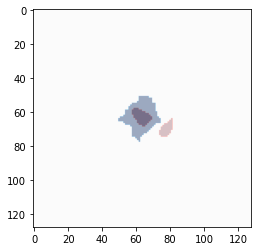

Accuracy: 0.971496582031


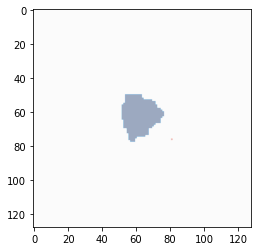

In [28]:
p_thresh = 0.5 + 2e-1
plt_up_to = 10
plotted = 0
for i in range(len(y_pred)):
    if plotted > plt_up_to:
        break
    
    y_pred_sample = (np.squeeze(y_pred[i]) > p_thresh).astype(int)
    y_test_sample = np.squeeze(data_val.get_y_tensor(i).numpy())
    if np.sum(y_test_sample) > 100:
        print("Accuracy:", np.sum(y_pred_sample == y_test_sample)/y_test_sample.size)
        plt.imshow(y_pred_sample, alpha=0.4, cmap='Reds')
        plt.imshow(y_test_sample, alpha=0.4, cmap='Blues')
        plt.show()
        plotted += 1

Accuracy: 0.957092285156


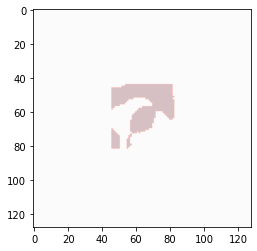

Accuracy: 0.990966796875


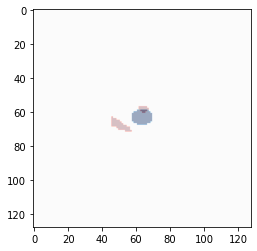

Accuracy: 0.962524414063


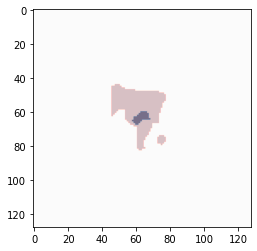

Accuracy: 0.979064941406


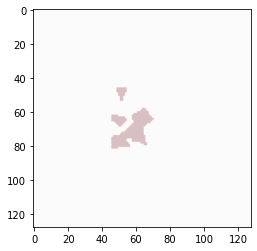

Accuracy: 0.98291015625


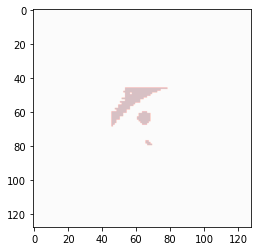

Accuracy: 0.977722167969


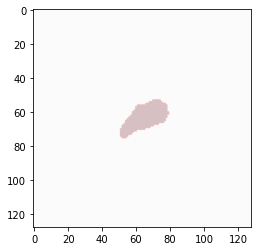

Accuracy: 0.953552246094


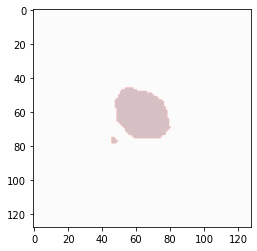

Accuracy: 0.985534667969


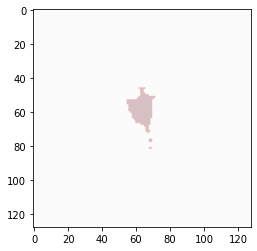

Accuracy: 0.994567871094


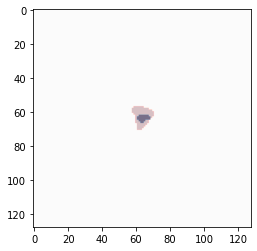

Accuracy: 0.982666015625


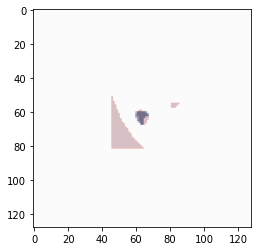

Accuracy: 0.983093261719


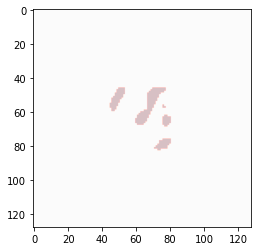

In [29]:
p_thresh = 0.5 + 2e-1
plt_up_to = 10
plotted = 0
for i in range(len(y_pred)):
    if plotted > plt_up_to:
        break
    
    y_pred_sample = (np.squeeze(y_pred[i]) > p_thresh).astype(int)
    y_test_sample = np.squeeze(data_val.get_y_tensor(i).numpy())
    if np.sum(y_test_sample) < 100:
        print("Accuracy:", np.sum(y_pred_sample == y_test_sample)/y_test_sample.size)
        plt.imshow(y_pred_sample, alpha=0.4, cmap='Reds')
        plt.imshow(y_test_sample, alpha=0.4, cmap='Blues')
        plt.show()
        plotted += 1